# Loading and Sorting the Pythia 8 Dataset

Classifying Pythia8 Quark and Gluon Jets

$\bf\text{Database Information: Pythia8 Quark and Gluon Jets for Energy Flow}$

Two datasets of quark and gluon jets generated with Pythia 8, one with all kinematically realizable quark jets and one that excludes charm and bottom quark jets (at the level of the hard process). The one without c and b jets was originally used in Energy Flow Networks: Deep Sets for Particle Jets. Generation parameters are listed below:

Pythia 8.226 (without bc jets), Pythia 8.235 (with bc jets), s√=14TeV
Quarks from WeakBosonAndParton:qg2gmZq, gluons from WeakBosonAndParton:qqbar2gmZg with the Z decaying to neutrinos
FastJet 3.3.0, anti-ki jets with R=0.4
pjetT∈[500,550]GeV,|yjet|<1.7
There are 20 files in each dataset, each in compressed NumPy format. Files including charm and bottom jets have 'withbc' in their filename. There are two arrays in each file

X: (100000,M,4), exactly 50k quark and 50k gluon jets, randomly sorted, where M is the max multiplicity of the jets in that file (other jets have been padded with zero-particles), and the features of each particle are its pt, rapidity, azimuthal angle, and pdgid.


y: (100000,), an array of labels for the jets where gluon is 0 and quark is 1.

[1] P. T. Komiske, E. M. Metodiev, J. Thaler, Energy Flow Networks: Deep Sets for Particle Jets, JHEP 01 (2019) 121, arXiv:1810.05165.

## Preprocess Data

1. We will utlize a package called particle in order to find the particle masses based on their pdgid's.
2. We will take the given features $p_{T,\alpha}^{(i)},y_{\alpha}^{(i)},\phi_{\alpha}^{(i)}$ to create new physically realizable features including the

$\bf\text{Transverse Mass Per Multiplicity}$ ($m_{\alpha,T}^{(i)}$)
$$m_{\alpha,T}^{(i)} = \sqrt{m_{\alpha}^{(i)^2} + p_{\alpha,T}^{(i)^2} }$$
$\bf\text{Energy Per Multiplicity}$ ($E_{\alpha}^{(i)}$)
$$E_{\alpha}^{(i)} = m_{\alpha,T}^{(i)} \text{cosh} y_{\alpha}^{(i)}$$
$\bf\text{Kinematic Momenta Components Per Multiplicity}$ ($\vec{p}_\alpha^{(i)} = (p_{x,\alpha}^{(i)},p_{y,\alpha}^{(i)},p_{z,\alpha}^{(i)})$ )
$$p_{x,\alpha}^{(i)} = p_{T,\alpha}^{(i)} \text{cos} \phi_{\alpha}^{(i)}$$
$$p_{y,\alpha}^{(i)} = p_{T,\alpha}^{(i)} \text{sin} \phi_{\alpha}^{(i)}$$
$$p_{z,\alpha}^{(i)} = m_{T,\alpha}^{(i)} \text{sinh} y_{\alpha}^{(i)}$$
Only add the above masses, energy, and three momentum components to the node features.

For additional checks, we also save

$\bf\text{Kinematic Momenta Components Per Jet}$ ($\vec{p}_\alpha = (p_{x,\alpha},p_{y,\alpha},p_{z,\alpha})$)
$$\vec{p}_\alpha = \sum_i \vec{p}_\alpha^{(i)}$$
$\bf\text{Transverse Momenta Per Jet}$ ($p_{T,\alpha} =\sqrt{ |( \sum_i p_{x,\alpha}^{(i)},  \sum_i p_{y,\alpha}^{(i)})|^2}$)
$$\vec{p}_{T,\alpha} = \sqrt{\left[  (\sum_i \vec{p}_{x,\alpha}^{(i)})^2 +   (\sum_i \vec{p}_{y,\alpha}^{(i)})^2 \right] }$$
$\bf\text{Mass Per Jet}$ ($m_{\alpha}$)
$$m_{\alpha} = \sqrt{ (E_\alpha - \vec{p}_{\alpha}^{(i)} \cdot \vec{p}_{\alpha}^{(i)} )^2}$$
$\bf\text{Rapidity Per Jet}$ ($y_{\alpha}$)
$$y_{\alpha} =\frac{1}{2}\ln \left( \frac{E_\alpha + p_{z,\alpha}}{E_\alpha - p_{z,\alpha}} \right)$$
2. Make Edges: Connect three nearest neighbors via $R = \sqrt{\Delta \phi^2 + \Delta y^2}$
$$a_{ij} = \sqrt{ \left( \phi_{\alpha}^{(i)} - \phi_{\alpha}^{(j)} \right)^2 + \left( y_{\alpha}^{(i)} - y_{\alpha}^{(j)} \right)^2 }$$
Note: One can also add an edge connection based on the invariant mass between particles
$$m_{ij} = \left( E_{\alpha}^{(i)} - E_{\alpha}^{(j)} \right)^2 - \left( \vec{p}_{\alpha}^{(i)} - \vec{p}_{\alpha}^{(j)} \right)^2$$
although this was not used in our analysis.

In [ ]:
# !pip install particle
# !pip install torch_geometric
# !pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-1.13.0+cpu.html
# pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-1.13.0+cpu.html

In [ ]:
import numpy as np
from numpy.random import default_rng
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import time
import os
import copy
from particle import Particle
from sklearn.model_selection import train_test_split
from gnn_egnn.preprocess import *

import torch
from torch import nn as nn
#from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.nn import Linear
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset, InMemoryDataset, download_url
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
from torch_geometric.nn import Sequential
from torch_geometric import nn
from torch_geometric.nn import global_mean_pool


torch.set_default_dtype(torch.float64)
device = "cuda" if torch.cuda.is_available() else "cpu"
print('Device: ',device)

np.random.seed(0)
torch.manual_seed(0)

Device:  cpu


In [ ]:
path = 'Data_wo_bc/pythia8/'

Run the code below to create two numpy arrays for the features X and labels Y out of the 20 data files without bottom and charm quarks in the Pythia 8 dataset.

In [ ]:
# files = []
# for i in range(20):
#     if i<10:
#         files.append(np.load(path+f'QG_jets_0{i}.npz', allow_pickle=True))
#     else:
#         files.append(np.load(path+f'QG_jets_{str(i)[0]+str(i)[1]}.npz', allow_pickle=True))

In [ ]:
# len(files)

In [ ]:
# M=np.zeros(len(files),)
# for i,file in enumerate(files):
#     lst = file.files
#     for j,item in enumerate(lst):
#         if j==0:
#             M[i] = file[item][0,:,0].shape[0]

In [ ]:
# max_multiplicity = int(M.max())

In [ ]:
# #names = []
# #data = []
# for i,file in enumerate(files):
#     lst = file.files
#     print(f'File: {i}')
#     for j,item in enumerate(lst):
#         #names.append(item)
#         #data.append(file[item])
#         if j==0:
#             if i==0:
#                 x_data = np.pad(array=file[item],pad_width=((0,0),(0,int(max_multiplicity-file[item].shape[1])),(0,0)), mode='constant', constant_values=((None,None),(None,0.),(None,None)))
#                 print('X Data Shape: ', x_data.shape)
#             else:
#                 x_new = np.pad(array=file[item],pad_width=((0,0),(0,int(max_multiplicity-file[item].shape[1])),(0,0)), mode='constant', constant_values=((None,None),(None,0.),(None,None)))
#                 print('X Data Shape: ', x_new.shape)
#                 x_data = np.vstack([x_data,x_new])
#         elif j==1:
#             if i==0:
#                 y_data = file[item]
#                 print('Y Data Shape: ', y_data.shape)
#             else:
#                 y_data = np.vstack([y_data,file[item]])
#                 print('Y Data Shape: ', y_data.shape)
#             #names.append(item)
#             #print(files[item].shape)#.item()['0'].shape)
#             #data.append(files[item])

In [ ]:
# np.save(path+'appended_data.npy',x_data)

In [ ]:
# np.save(path+'appended_labels.npy',y_data)

Of course, I have already done this, therefore, they can be loaded in as below.

In [ ]:
x_data = np.load(path+'appended_data.npy')
y_data = np.load(path+'appended_labels.npy').reshape(x_data.shape[0],)

In [ ]:
x_data[:,:,:].shape

(2000000, 148, 4)

In [ ]:
y_data.shape

(2000000,)

## Data Checks

In [ ]:
x_data[0,:,3]

array([  22.,   22., -211., -321., -211.,   22.,   22.,  211.,  321.,
       -211.,   22.,   22.,   22.,   22.,   22.,   22.,   22.,   22.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,

Look at a Particular Jet

In [ ]:
i=13

In [ ]:
(x_data[i,:,0]>0).sum()

49

Text(0.5, 0, 'particle number')

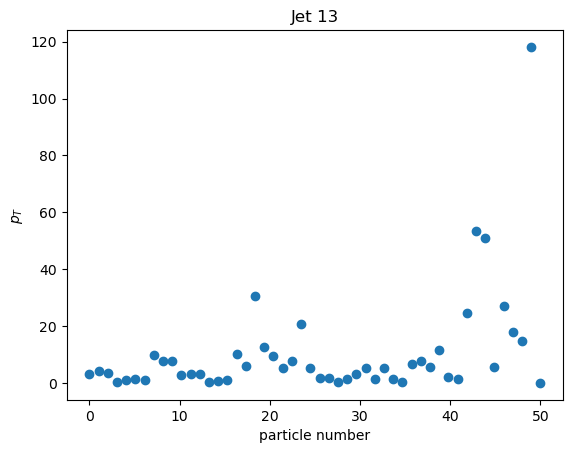

In [ ]:
i=13
id2 = 50
plt.scatter(np.linspace(0,id2,id2),x_data[i,:id2,0])
plt.ylabel('$p_T$')
plt.title(f'Jet {i}')
plt.xlabel('particle number')

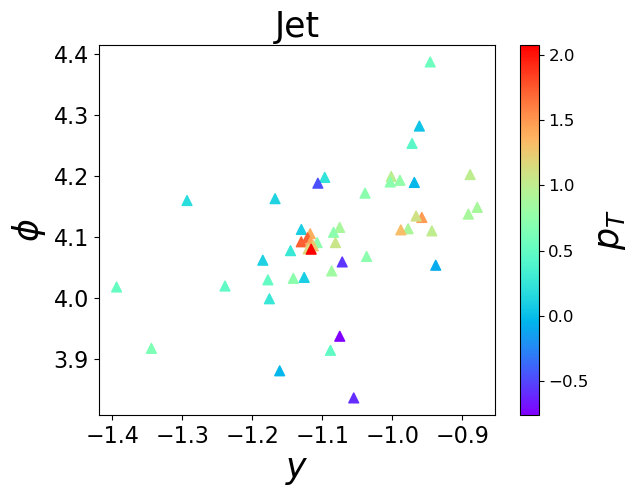

In [ ]:
id2-=1
plt.scatter(x_data[13,:id2,1],x_data[13,:id2,2],c=np.log10(x_data[13,:id2,0]),s=50,marker='^',cmap='rainbow')
plt.title(f'Jet',fontsize=25)
plt.ylabel('$\phi$',fontsize=25)
plt.xlabel('$y$',fontsize=25)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
cbar = plt.colorbar()
cbar.set_label(label='$p_T$',size=25)
cbar.ax.tick_params(labelsize=12)
plt.savefig('jet_example.png',bbox_inches='tight')

In [ ]:
np.sum(x_data[13,:,0]>1e-10)

49

Out of all jets, find the minimum number of particles measured amongst them

In [ ]:
np.min(np.sum(x_data[:,:,0]>1e-10,axis=1))

1

In [ ]:
np.argmin(np.sum(x_data[:,:,0]>1e-10,axis=1))

70617

In [ ]:
id3 = 70617

In [ ]:
x_data[id3,:,3]

array([22.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.])

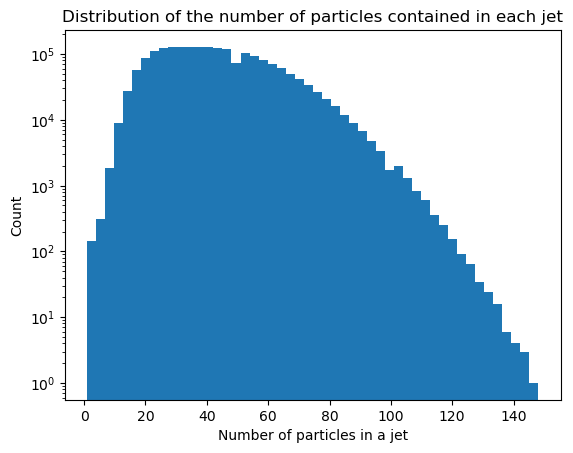

In [ ]:
plt.hist(np.sum(x_data[:,:,0]>1e-10,axis=1),bins=50)
plt.yscale('log')
plt.ylabel('Count')
plt.xlabel('Number of particles in a jet')
plt.title('Distribution of the number of particles contained in each jet')
plt.show()

How many jets contain exactly 25 particles

In [ ]:
(np.sum(x_data[:,:,0]>1e-10,axis=1)==25).sum()

40166

In [ ]:
pt = x_data[:,:,0]
phi= x_data[:,:,2]
px = pt*np.cos(phi)
py = pt*np.sin(phi)
px_tot = np.sum(px,axis=1)
py_tot = np.sum(py,axis=1)
sum_sq = px_tot**2 + py_tot**2
pt_per_jet = np.sqrt(sum_sq)

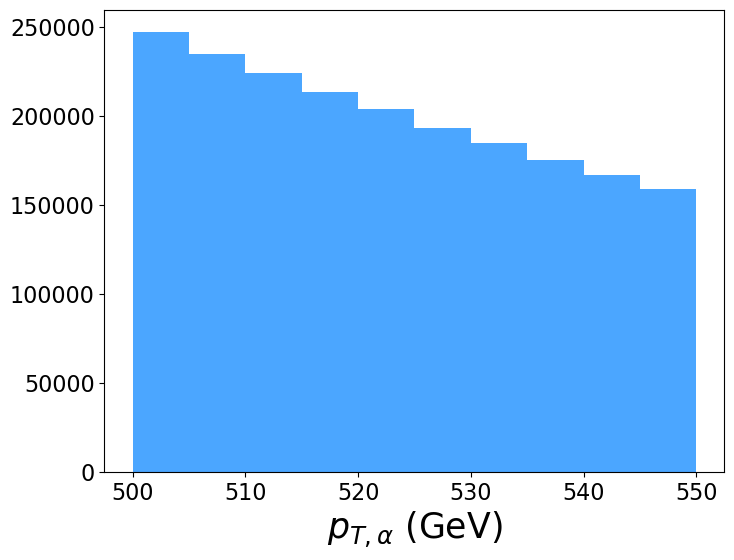

In [ ]:
fig = plt.figure(figsize=(8,6))
plt.hist(pt_per_jet, color='dodgerblue', alpha=0.8, linewidth=1.2)
# plt.title('Distribution of total transverse momentum per jet',fontsize=25)
# plt.ylabel('Count',fontsize=25)
plt.xlabel(r'$p_{T,\alpha}$ (GeV)', fontsize=25)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('pt_distribution.png',bbox_inches='tight')

In [ ]:
inds25 = (np.sum(x_data[:,:,0]>1e-10,axis=1)==25)

In [ ]:
x25 = x_data[inds25,:25,:]

In [ ]:
x25_sorted = np.zeros((x25.shape[0],x25.shape[1]))
for i in range(40166):
    x25_sorted[i,:] = np.sort(x25[i,:,0])[::-1]

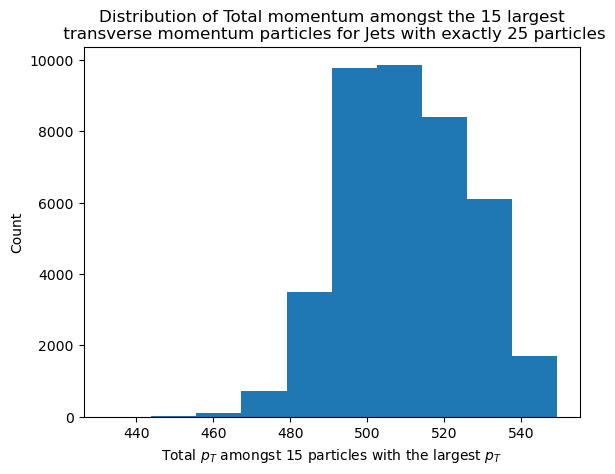

In [ ]:
plt.hist(np.sum(x25_sorted[:,:15],axis=1))
plt.title('Distribution of Total momentum amongst the 15 largest\n transverse momentum particles for Jets with exactly 25 particles')
plt.ylabel('Count')
plt.xlabel('Total $p_T$ amongst 15 particles with the largest $p_T$')
plt.show()

Because this is not representative of the entire dataset moemntum distribution, reduce to 10 particles and take all of them

In [ ]:
inds10 = (np.sum(x_data[:,:,0]>1e-10,axis=1)==10)

In [ ]:
x10 = x_data[inds10,:10,:]
y10 = y_data[inds10]

In [ ]:
y10.shape[0]

1691

In [ ]:
(y10==1).sum()

1639

In [ ]:
i=0

In [ ]:
x10[i,:,0]

array([2.45459550e-01, 4.96069327e+00, 3.48907409e+00, 1.11288630e+00,
       1.94903155e-01, 8.23072425e-01, 2.68559874e+00, 2.50188856e-01,
       4.92518385e+02, 2.26165834e-02])

In [ ]:
np.sort(x10[i,:,0])[::-1]

array([4.92518385e+02, 4.96069327e+00, 3.48907409e+00, 2.68559874e+00,
       1.11288630e+00, 8.23072425e-01, 2.50188856e-01, 2.45459550e-01,
       1.94903155e-01, 2.26165834e-02])

In [ ]:
sort_nodes = np.argsort(x10[i,:,0])[::-1]

In [ ]:
x10i_sorted = x10[i,sort_nodes,:]

In [ ]:
x10i_sorted[:,0]

array([4.92518385e+02, 4.96069327e+00, 3.48907409e+00, 2.68559874e+00,
       1.11288630e+00, 8.23072425e-01, 2.50188856e-01, 2.45459550e-01,
       1.94903155e-01, 2.26165834e-02])

In [ ]:
x10_sorted = np.zeros((x10.shape[0],x10.shape[1]))
for i in range(x10.shape[0]):
    x10_sorted[i,:] = np.sort(x10[i,:,0])[::-1]

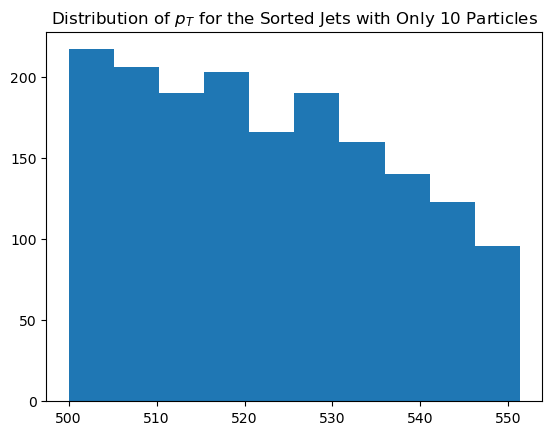

In [ ]:
plt.hist(np.sum(x10_sorted[:,:10],axis=1))
plt.title('Distribution of $p_T$ for the Sorted Jets with Only 10 Particles')
plt.show()

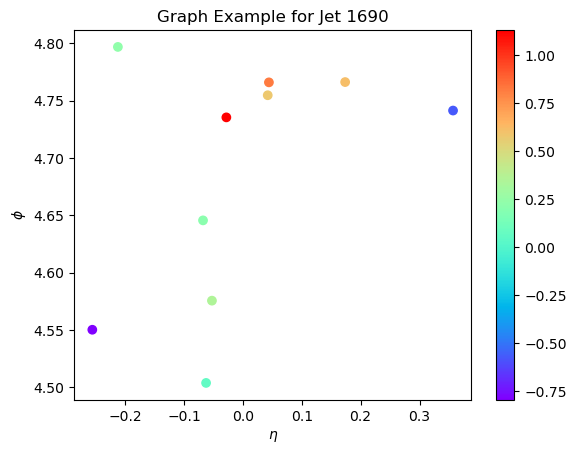

In [ ]:
id4=10
plt.scatter(x_data[0,:id4,1],x_data[0,:id4,2],c=np.log10(x_data[0,:id4,0]),cmap='rainbow')
plt.colorbar()
plt.title(f'Graph Example for Jet {i}')
plt.ylabel('$\phi$')
plt.xlabel('$\eta$')
plt.show()

In [ ]:
(y10==1).sum()/y10.shape[0]

0.9692489651094027

As shown above, although the reduction to 10 particle jets seems nice, they are predominantly (97%) classified as quarks (y=1)

For this reason, take largest 10 momentum particles for all jets with $\geq 10$ particles. This will be representative of the entire dataset with $\geq 10$ particles.

In [ ]:
inds10 = np.logical_and(np.sum(x_data[:,:,0]>1e-10,axis=1)>=10,np.sum(x_data[:,:,0]>1e-10,axis=1)<=120)

In [ ]:
x10 = x_data[inds10,:,:]
y10 = y_data[inds10]

In [ ]:
y10.shape[0]

1997445

In [ ]:
(y10==1).sum()

997805

Below is the array we will use containing jets with at least 10 partciles sorted by their transverse momentum (largest to smallest).

In [ ]:
x10_all_features_correctly_sorted = np.zeros((x10.shape[0],10,x10.shape[2]))
for i in range(x10.shape[0]):
    sort_nodes = np.argsort(x10[i,:,0])[::-1]
    x10_all_features_correctly_sorted[i,:,:] = x10[i,sort_nodes[:10],:]

Choose a small fraction of jets to check the preprocessing steps

In [ ]:
Ntry = 1000

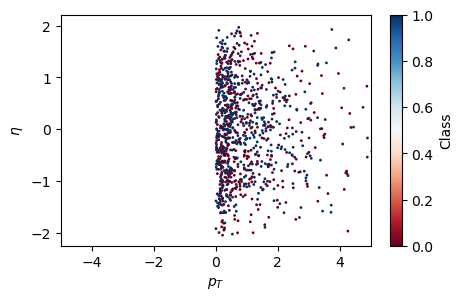

In [ ]:
plt.figure(figsize=(5,3))
plt.scatter(x_data[:Ntry,0,0],x_data[:Ntry,0,1],s=1,c=y_data[:Ntry],cmap='RdBu')#,vmin=0.,vmax=1.)
# plt.scatter(-x_data[:Ntry,0,0],x_data[:Ntry,0,1],s=1,c=y_data[:Ntry],cmap='RdBu')#,vmin=0.,vmax=1.)
plt.xlabel('$p_T$')
plt.ylabel('$\eta$')
plt.xlim(-5,5)
plt.title('')
plt.colorbar(label='Class')

In [ ]:
unique_particles = np.unique(x_data[:Ntry,:,3])

In [ ]:
unique_particles

array([-2212., -2112.,  -321.,  -211.,   -13.,   -11.,     0.,    11.,
          13.,    22.,   130.,   211.,   321.,  2112.,  2212.])

In [ ]:
for i,particle in enumerate(unique_particles):
    if particle!=0:
        symbol =Particle.from_pdgid(particle).name
        mass = Particle.from_pdgid(particle).mass/1000
        print(i,particle,symbol,mass)

0 -2212.0 p~ 0.93827208816
1 -2112.0 n~ 0.9395654204999999
2 -321.0 K- 0.49367700000000003
3 -211.0 pi- 0.13957039000000002
4 -13.0 mu+ 0.1056583755
5 -11.0 e+ 0.0005109989499999999
7 11.0 e- 0.0005109989499999999
8 13.0 mu- 0.1056583755
9 22.0 gamma 0.0
10 130.0 K(L)0 0.49761099999999997
11 211.0 pi+ 0.13957039000000002
12 321.0 K+ 0.49367700000000003
13 2112.0 n 0.9395654204999999
14 2212.0 p 0.93827208816


In [ ]:
#np.save('masses.npy',masses)

In [ ]:
# masses = torch.tensor(np.load('masses.npy'))

In [ ]:
print('--- Finding All Unique Particles ---')
unique_particles = np.unique(x_data[:Ntry,:,3])
print()
print('--- Inserting Masses ---')
masses = np.zeros((x_data[:Ntry].shape[0],x_data[:Ntry].shape[1]))
for i,particle in tqdm(enumerate(unique_particles)):
    if particle!=0:
        mass = Particle.from_pdgid(particle).mass/1000
        inds = np.where(particle==x_data[:Ntry,:,3])
        masses[inds]=mass # GeV
print()
print('--- Calculating Momenta and Energies ---')
#theta = torch.arctan(torch.exp(-X[:,:,1]))*2 # polar angle
pt        = x_data[:Ntry,:,0]     # transverse momentum
rapidity  = x_data[:Ntry,:,1]     # rapidity
phi       = x_data[:Ntry,:,2]     # azimuthal angle

mt        = np.sqrt(pt**2+masses**2) # Transverse mass
energy    = mt*np.cosh(rapidity) # Energy per multiplicity bin
e_per_jet = energy.sum(axis=1)  # total energy per jet summed across multiplicity bins

px = pt*np.cos(phi)  # momentum in x
py = pt*np.sin(phi)  # momentum in y
pz = mt*np.sinh(rapidity)  # momentum in z

# three momentum
p = np.stack(( px[:,:,None],
               py[:,:,None],
               pz[:,:,None]), axis=2 )

p_per_jet        = np.sum(p,axis=1)  # total componet momentum per jet
#pt_per_Mbin      = np.sqrt(np.sum(p_per_jet[:,:2]**2, axis=1))  # transverse momentum per jet
#mass_per_jet     = np.sqrt(e_per_jet**2-np.sum(p_per_jet**2,axis=1)) # mass per jet
#rapidity_per_jet = np.log( (e_per_jet+p_per_jet[:,2])/(e_per_jet-p_per_jet[:,2]) )/2  # rapidity per jet from analytical formula
#end_multiplicity_indx_per_jet = np.sum(pt!=0,axis=1).int() # see where the jet (graph) ends

--- Finding All Unique Particles ---

--- Inserting Masses ---


15it [00:00, 730.10it/s]


--- Calculating Momenta and Energies ---


NOTE: The plots below are only a test for 1000 of the two million total jets.

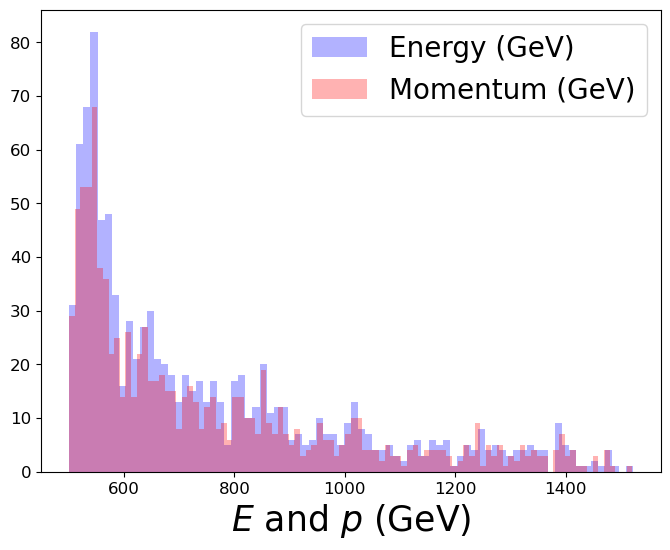

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(e_per_jet, color='b', alpha=0.3, bins=80, label='Energy (GeV)')
plt.hist(np.sqrt(np.sum((p_per_jet)**2,axis=1)), color='r', alpha=0.3, bins=100,label='Momentum (GeV)')
# plt.title('Distributions of Total Energy and Momenta Per Jet')
plt.xlabel('$E$ and $p$ (GeV)',fontsize=25)
# plt.ylabel('Count')
plt.legend(fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('Ep_distributions.png',bbox_inches='tight')

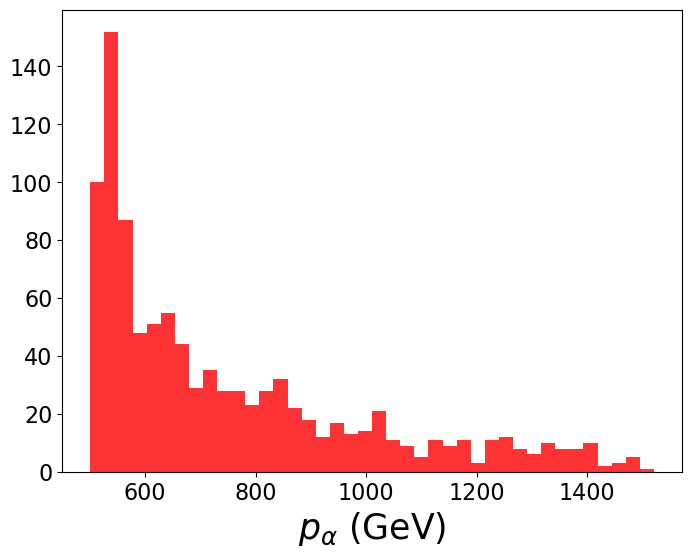

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(np.sqrt(np.sum((p_per_jet)**2,axis=1)),color='r', alpha=0.8, bins=40)#,label='Momentum (GeV)')
plt.xlabel(r'$p_{\alpha}$ (GeV)',fontsize=25)
# plt.legend(fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('p_distribution.png',bbox_inches='tight')

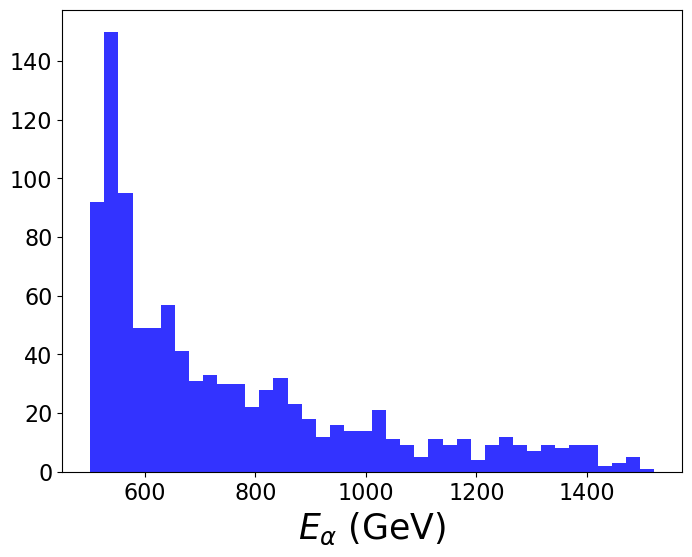

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(e_per_jet, color='b', alpha=0.8, bins=40)#, label='Energy (GeV)')
plt.xlabel(r'$E_\alpha$ (GeV)',fontsize=25)
# plt.legend(fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('e_distribution.png',bbox_inches='tight')

## Preprocess data

In [ ]:
# x_data_proc, y_data_proc, edge_tensor, edge_indx_tensor, edge_attr_matrix, graph_help = preprocess_general(x_data[indices],y_data[indices]) #,masses[:N])
# x_data_proc, y_data_proc, edge_tensor, edge_indx_tensor, edge_attr_matrix, graph_help = preprocess_fixed_nodes(x10_all_features_correctly_sorted[indices],y10[indices],nodes_per_graph = nodes_per_graph) #,masses[:N])
# N = x_data_proc.shape[0]

In [ ]:
N=12500
rng = default_rng(seed=0)
indices = rng.choice(x10.shape[0], size=N, replace=False)
nodes_per_graph = 10
x10_sorted_12500 = x10_all_features_correctly_sorted[indices]
y10_sorted_12500 = y10[indices]

In [ ]:
# np.save('x10_sorted_12500.npy',x10_all_features_correctly_sorted[indices])
# np.save('y10_sorted_12500.npy',y10[indices])

In [ ]:
# N=12500
# x10_sorted_12500 = np.load('x10_sorted_12500.npy')
# y10_sorted_12500 = np.load('y10_sorted_12500.npy')

In [ ]:
nodes_per_graph = 10
x_data_proc, y_data_proc, edge_tensor, edge_indx_tensor, edge_attr_matrix, graph_help = preprocess_fixed_nodes(x10_sorted_12500,y10_sorted_12500,nodes_per_graph = nodes_per_graph) #,masses[:N])
N = x_data_proc.shape[0]

--- Finding All Unique Particles ---

--- Inserting Masses ---


14it [00:00, 378.55it/s]



--- Calculating Momenta and Energies ---

--- Calculating Edge Tensors ---


100%|██████████████████████████████████████████████████████████████████████| 12500/12500 [00:13<00:00, 939.49it/s]


In [ ]:
# N=100000
# rng = default_rng(seed=0)
# indices = rng.choice(x_data.shape[0], size=N, replace=False)
# nodes_per_graph = 10
# # x_data_proc, y_data_proc, edge_tensor, edge_indx_tensor, edge_attr_matrix, graph_help = preprocess_general(x_data[indices],y_data[indices]) #,masses[:N])
# x_data_proc, y_data_proc, edge_tensor, edge_indx_tensor, edge_attr_matrix, graph_help = preprocess_fixed_nodes(x_data[indices],y_data[indices],nodes_per_graph = nodes_per_graph) #,masses[:N])
# N = x_data_proc.shape[0]

In [ ]:
print('----- Check for the correctly sized tensors -----')
print()
print(f'Jet Data: {x_data_proc.shape}')
print(f'Classification: {y_data_proc.shape}')
print(f'Full Edge Information: {edge_tensor.shape}')
print(f'Edge Index Information: {edge_indx_tensor.shape}')
print(f'Edge Attribute Information: {edge_attr_matrix.shape}')
print(f'Graph Structure Information: {graph_help.shape}')
print('\n')
print('----- Check that each tensor is normalized -----')
print()
print(f'Jet Data max: {torch.max(x_data_proc)}')
print(f'Classification Max: {torch.max(y_data_proc)}')
print(f'Edge Length Max: {torch.max(edge_tensor)}')

----- Check for the correctly sized tensors -----

Jet Data: torch.Size([12500, 10, 8])
Classification: torch.Size([12500])
Full Edge Information: torch.Size([12500, 10, 10])
Edge Index Information: torch.Size([12500, 2, 90])
Edge Attribute Information: torch.Size([12500, 90, 1])
Graph Structure Information: torch.Size([12500, 4])


----- Check that each tensor is normalized -----

Jet Data max: 1.0
Classification Max: 1
Edge Length Max: 1.0


In [ ]:
print('----- Check the structure of the dataset -----')
print()
print(f'Number of graphs (jets): {x_data_proc.shape[0]}')
print(r'Number of features per node (p_T(M),y,phi,m,E,px,py,pz): '+f'{x_data_proc.shape[2]}')
print(f'Number of classes (2: Quarks or Gluons): {np.unique(y_data_proc).shape[0]}')
print()
print('----- Check the structure of one graph -----')
print()
i=0
number_of_edges = graph_help[i,3]
# Gather some statistics about the first graph.
print(f'Number of nodes (particle IDs): {x_data_proc[i,:,0].shape[0]}')
print(f'Number of edges: {number_of_edges}')
print(f'Average node degree: {number_of_edges / x_data_proc[i,:,0].shape[0]:.2f}')
print(f'Is undirected: {True}')

----- Check the structure of the dataset -----

Number of graphs (jets): 12500
Number of features per node (p_T(M),y,phi,m,E,px,py,pz): 8
Number of classes (2: Quarks or Gluons): 2

----- Check the structure of one graph -----

Number of nodes (particle IDs): 10
Number of edges: 90.0
Average node degree: 9.00
Is undirected: True


In [ ]:
# Create a dataset class
class Create_Dataset(Dataset):
    def __init__(self, edge_index, x, edge_attr, y, graph_info, transform=None):
        self.edge_index = edge_index
        self.x          = x
        self.edge_attr  = edge_attr
        self.y          = y
        self.graph_info = graph_info
        self.transform  = transform

    def __len__(self):
        return self.y.shape[0]

    # Could also just define an x,y,z then pass these variables
    # in the training functions over the loop for batch (actually think that way is easier to read)
    def __getitem__(self, index):
        sample = {'edge_index': self.edge_index[index,:,:self.graph_info[index,3]],
                'x': self.x[index,:int(self.graph_info[index,2]),:],
                'edge_attr': self.edge_attr[index,:self.graph_info[index,3]],
                'y': self.y[index] }

        if self.transform is not None:
            sample = self.transform(sample)
        return sample

In [ ]:
train_index   = int(N*0.8)#int(N*0.7)
val_index    = int(N*0.9)
batch_size = 64
# Create Datasets for Torch for the training and testing pahses
dataset = []
for i in tqdm(range(N)):
    dataset.append(Data(edge_index=edge_indx_tensor[i,:,:],
                        x=x_data_proc[i,:,:],
                        edge_attr=edge_attr_matrix[i,:],
                        y=y_data_proc[i]))

training_data = dataset[:train_index]
val_data      = dataset[train_index:val_index]
test_data     = dataset[val_index:]

# Create data loaders
train_dataloader = DataLoader(training_data,
                              batch_size = batch_size,
                              shuffle = True,
                              num_workers = 0)

val_dataloader  = DataLoader(val_data,
                              batch_size = batch_size,
                              shuffle = False,
                              num_workers = 0)

test_dataloader  = DataLoader(test_data,
                              batch_size = batch_size,
                              shuffle = False,
                              num_workers = 0)

print(f'Number of training graphs: {train_index}')
print(f'Number of validation graphs: {val_index-train_index}')
print(f'Number of test graphs: {N-val_index}')

100%|█████████████████████████████████████████████████████████████████████| 12500/12500 [00:02<00:00, 4227.50it/s]

Number of training graphs: 10000
Number of validation graphs: 1250
Number of test graphs: 1250


In [ ]:
train_y = 0
for idx,graph in enumerate(training_data):
    if graph.y==1:
        train_y+=1
print(train_y)

4982


In [ ]:
val_y = 0
for idx,graph in enumerate(val_data):
    if graph.y==1:
        val_y+=1
print(val_y)

658


In [ ]:
test_y = 0
for idx,graph in enumerate(test_data):
    if graph.y==1:
        test_y+=1
print(test_y)

583
